# GAN, 오토인코더

## 적대적 신경망 실행

### GAN 모델 만들기

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 생성자 모델
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

In [3]:
# 판별자 모델
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

In [4]:
# 생성자와 판별자 모델 연결 : gan 모델
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


1/1 [==============================] - 0s 366ms/step
epoch:0  d_loss:0.6793  g_loss:0.4681
1/1 [==============================] - 0s 23ms/step
epoch:1  d_loss:0.4578  g_loss:0.1177
1/1 [==============================] - 0s 25ms/step
epoch:2  d_loss:0.4413  g_loss:0.0163
1/1 [==============================] - 0s 12ms/step
epoch:3  d_loss:0.4758  g_loss:0.0056
1/1 [==============================] - 0s 12ms/step
epoch:4  d_loss:0.4953  g_loss:0.0101
1/1 [==============================] - 0s 14ms/step
epoch:5  d_loss:0.4873  g_loss:0.0481
1/1 [==============================] - 0s 26ms/step
epoch:6  d_loss:0.4643  g_loss:0.1726
1/1 [==============================] - 0s 40ms/step
epoch:7  d_loss:0.4873  g_loss:0.2940
1/1 [==============================] - 0s 19ms/step
epoch:8  d_loss:0.5224  g_loss:0.3345
1/1 [==============================] - 0s 41ms/step
epoch:9  d_loss:0.5095  g_loss:0.3566
1/1 [==============================] - 0s 34ms/step
epoch:10  d_loss:0.4695  g_loss:0.4410
1/1 [===

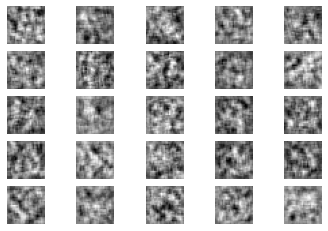

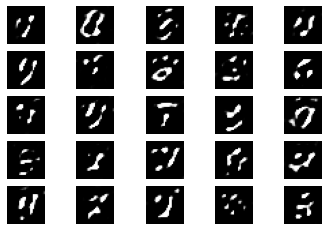

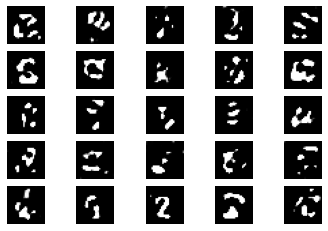

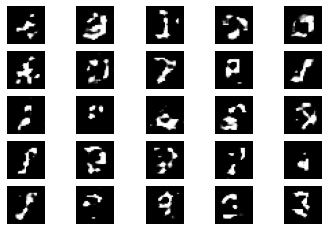

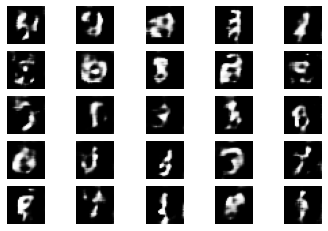

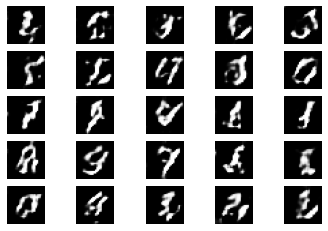

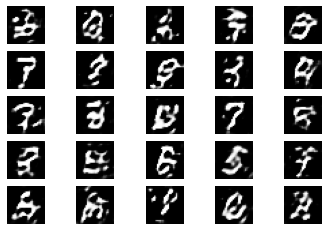

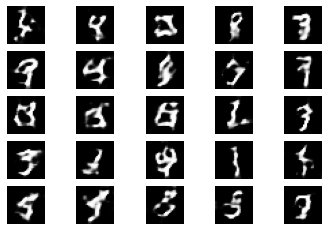

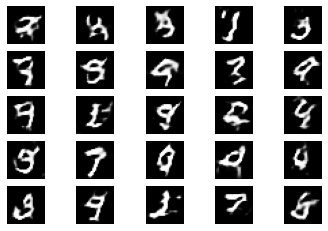

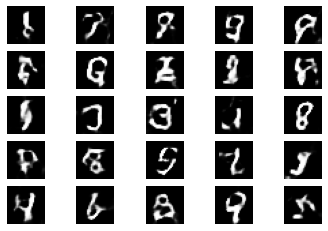

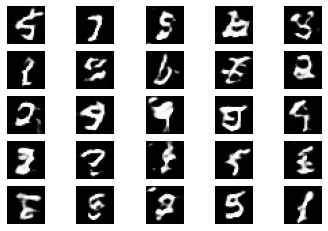

In [5]:
# 신경망 실행 함수
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터

  (X_train, _), (_, _) = mnist.load_data()  # 이전에 사용한 MNIST 다시 이용 (단, 테스트 과정 필요 x 이미지만 사용 -> X_train만 불러오기)
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5  # 픽셀 값 : 0 ~ 255 사이 값 (255로 나누어 줄때는 0~1 사이의 값, -127.5 하고 /127.5 때문에 -1에서 1사이의 값)
  # X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
          # 실제 데이터 판별자에 입력 부분
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          imgs = X_train[idx]
          d_loss_real = discriminator.train_on_batch(imgs, true)

          # 가상 이미지 판별자에 입력 부분
          noise = np.random.normal(0, 1, (batch_size, 100))
          gen_imgs = generator.predict(noise)
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

          # 오차 계산
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          g_loss = gan.train_on_batch(noise, true)

          print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 중간 과정을 이미지로 저장, gan_images 폴더 저장
          if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("./gan_mnist_%d.png" % i)

gan_train(2001, 32, 200)  # 2000번 반복, 배치 사이즈 32,  200번마다 결과가 저장

## 이미지의 특징 추출, 오토인코더

### 오토인코더 실습

In [6]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape

import matplotlib.pyplot as plt
import numpy as np

In [7]:
# MNIST 데이터셋

(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

In [8]:
# 생성자 모델
autoencoder = Sequential()

In [9]:
# 인코딩 부분
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28,28,1), activation='relu'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu'))

In [10]:
# 디코딩 부분
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(16, kernel_size=3, activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))

In [11]:
# 전체 구조 확인
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 8)          

In [12]:
# 컴파일 및 학습
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))

Epoch 1/50
469/469 [==============================] - 4s 6ms/step - loss: 0.2050 - val_loss: 0.1292
Epoch 2/50
469/469 [==============================] - 3s 5ms/step - loss: 0.1210 - val_loss: 0.1134
Epoch 3/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1113 - val_loss: 0.1078
Epoch 4/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1063 - val_loss: 0.1035
Epoch 5/50
469/469 [==============================] - 3s 5ms/step - loss: 0.1032 - val_loss: 0.1007
Epoch 6/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1009 - val_loss: 0.0986
Epoch 7/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0991 - val_loss: 0.0971
Epoch 8/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0978 - val_loss: 0.0959
Epoch 9/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0966 - val_loss: 0.0949
Epoch 10/50
469/469 [==============================] - 3s 5ms/step - loss: 0.0957 - val_loss: 0.0938

313/313 [==============================] - 1s 3ms/step


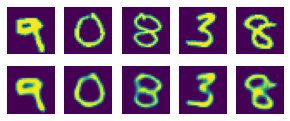

In [13]:
# 학습된 결과 출력
random_test = np.random.randint(X_test.shape[0], size=5)  # 테스트 이미지 랜덤 불러오기
ae_imgs = autoencoder.predict(X_test)  # 오토인코더 모델에 넣기

plt.figure(figsize=(7, 2))  # 출력 이미지 크기 정하기

for i, image_idx in enumerate(random_test): # 랜덤 이미지 차례로 나열
   ax = plt.subplot(2, 7, i + 1) 
   plt.imshow(X_test[image_idx].reshape(28, 28)) # 테스트 이미지 그대로 보여주기
   ax.axis('off')
   ax = plt.subplot(2, 7, 7 + i +1)
   plt.imshow(ae_imgs[image_idx].reshape(28, 28))  # 오토인코딩 결과 다음열 출력
   ax.axis('off')
plt.show()